<div class="alert alert-block alert-success">
    <h1 align="center">Plant Classification</h1>
    <h3 align="center">A2NDL POLIMI</h3>

</div>

### 1-Mount Google drive and unzip data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!unzip -qq "/content/drive/MyDrive/public_data.zip" -d "/content"

### 2-Import Libraries

In [ ]:
import os, datetime
import warnings
import numpy as np
import logging
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
tf.keras.callbacks
from sklearn.metrics import mean_squared_error
from keras import callbacks
from keras import layers
from keras import models
from keras.layers import Dropout
import keras
from keras import optimizers
from sklearn import preprocessing
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import cv2, glob, random, os, time, shutil, datetime,time, keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D,MaxPool2D, BatchNormalization, Activation, Input, Add, Dense, ZeroPadding2D,Flatten, AveragePooling2D, Rescaling
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras import layers, callbacks , metrics
from joblib import Parallel, delayed
from sklearn.metrics import accuracy_score, confusion_matrix
%load_ext tensorboard

### 3-Fix randomness and hide warnings

In [ ]:
seed = 42
#####
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'
#####
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
#####
np.random.seed(seed)
random.seed(seed)

### 4-Set first parameters of tensorflow

In [ ]:
# Import tensorflow
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


### 5-Load dataset

In [ ]:
dataset = np.load("/content/public_data.npz", allow_pickle=True)

### EDA On Dataset

In [ ]:
# Watch keys available in the numpy array
keys = list(dataset.keys())
print('keys in our dataset are: ', keys)
print('*'*100)

# look at data
data = dataset["data"]
no_images = data.shape[0]
size_images = data.shape[1:3]
print('Data shape: ',data.shape)
print('*'*100)

# Lool aat labels
labels = dataset["labels"]
no_labels = labels.shape[0]
print("Labels are : ",labels)
print('*'*100)

# Look at bing balanced or imblanced
_, counts = np.unique(labels,return_counts=True)
no_healthy_images = counts[0]
no_unhealthy_images = counts[1]
info_table_dict = {"no_images":no_images, "image_width": size_images[0],"image_length": size_images[1], "no_labels":no_labels,
                   "no_healthy_images":no_healthy_images,"percentage%":no_healthy_images*100/no_labels,
                   "no_unhealthy_images":no_unhealthy_images,"percentage %":no_unhealthy_images*100/no_labels }
info_table = pd.DataFrame(info_table_dict, index =['value'])
info_table

keys in our dataset are:  ['data', 'labels']
****************************************************************************************************
Data shape:  (5200, 96, 96, 3)
****************************************************************************************************
Labels are :  ['healthy' 'healthy' 'healthy' ... 'healthy' 'healthy' 'healthy']
****************************************************************************************************


,no_images,image_width,image_length,no_labels,no_healthy_images,percentage%,no_unhealthy_images,percentage %
value,5200,96,96,5200,3199,61.519231,2001,38.480769


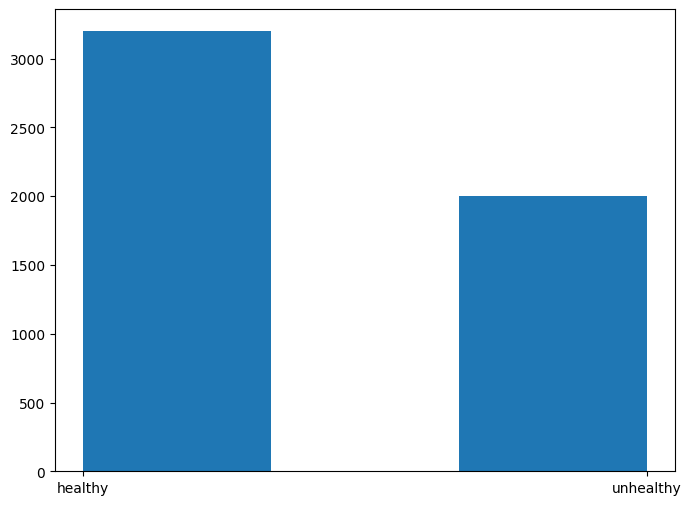

In [ ]:
plt.figure(figsize=(8,6))
plt.hist(labels, bins=3,align='mid')
plt.show()

In [ ]:
# Turn healty and unhealthy labels to two classes of 0 and 1, using labelEncoder
before = labels.copy()

# Create a LabelEncoder
label_encoder = preprocessing.LabelEncoder()
# Fit and transform the encoder on the original array
labels = label_encoder.fit_transform(labels)

after = labels.copy()
print(f"before label encoding list is like this :{before}. And, unique items are: {np.unique(before)}")
print(f"after label encoding list is like this :{after}. And, unique items are: {np.unique(after)}")

before label encoding list is like this :['healthy' 'healthy' 'healthy' ... 'healthy' 'healthy' 'healthy']. And, unique items are: ['healthy' 'unhealthy']
after label encoding list is like this :[0 0 0 ... 0 0 0]. And, unique items are: [0 1]


In [ ]:
data[1]

array([[[ 94., 125.,  83.],
        [ 46.,  79.,  34.],
        [ 62., 103.,  47.],
        ...,
        [129., 178., 133.],
        [125., 174., 127.],
        [124., 173., 126.]],

       [[ 67.,  98.,  56.],
        [ 31.,  64.,  19.],
        [ 57.,  98.,  42.],
        ...,
        [129., 177., 135.],
        [129., 178., 133.],
        [130., 179., 134.]],

       [[  1.,  32.,   0.],
        [  0.,  30.,   0.],
        [ 53.,  94.,  38.],
        ...,
        [139., 185., 149.],
        [135., 181., 144.],
        [134., 180., 143.]],

       ...,

       [[144., 194., 159.],
        [139., 189., 154.],
        [139., 189., 154.],
        ...,
        [138., 193., 151.],
        [138., 193., 153.],
        [142., 197., 157.]],

       [[142., 192., 157.],
        [142., 192., 157.],
        [146., 196., 161.],
        ...,
        [147., 201., 165.],
        [145., 199., 163.],
        [152., 206., 170.]],

       [[141., 191., 156.],
        [143., 193., 158.],
        [148., 1

### 5-Splitting data

In [ ]:
x_training_data, x_test, y_training_data, y_test = train_test_split(
    data,
    labels,
    test_size = 0.2,
    shuffle =True,
    random_state=seed,
    stratify=labels)

####5-1 hold_out splitting

In [ ]:
# Further split the combined training and validation set into a training set and a validation set
x_train, x_val, y_train, y_val = train_test_split(
    x_training_data,
    y_training_data,
    test_size = len(x_test), # Ensure validation set size matches test set size--> Why??
    random_state=seed,
    shuffle =True,
    stratify=y_training_data)

In [ ]:
# Print the shapes of the resulting datasets
print('X_train.shape:',x_train.shape,'y_train.shape:', y_train.shape)
print('X_val.shape:',x_val.shape, 'y_val.shape:',y_val.shape)
print('X_test.shape:',x_test.shape,'y_test.shape', y_test.shape)

X_train.shape: (3120, 96, 96, 3) y_train.shape: (3120,)
X_val.shape: (1040, 96, 96, 3) y_val.shape: (1040,)
X_test.shape: (1040, 96, 96, 3) y_test.shape (1040,)


In [ ]:
#Understand the same portion of two classes after splititng using stratify
_,count = np.unique(y_train,return_counts=True)
info_table1_dict = {"no_train_images":x_train.shape[0],
                    "no_healthy_images":count[0],"percentage%":count[0]*100/x_train.shape[0],
                   "no_unhealthy_images":count[1],"percentage %":count[1]*100/x_train.shape[0]}
info_table1 = pd.DataFrame(info_table1_dict, index =['value'])
info_table1

,no_train_images,no_healthy_images,percentage%,no_unhealthy_images,percentage %
value,3120,1919,61.50641,1201,38.49359


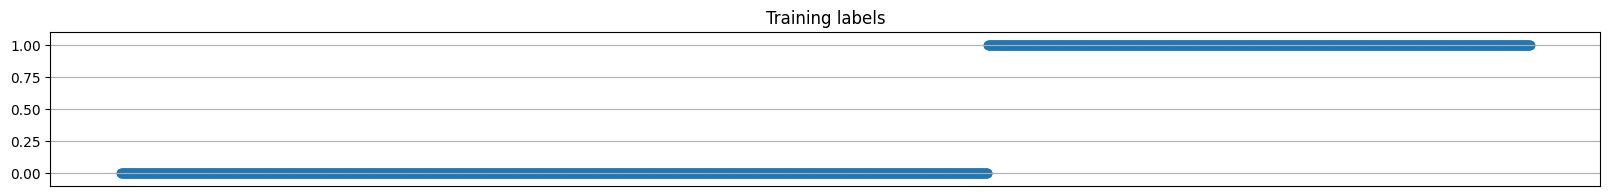

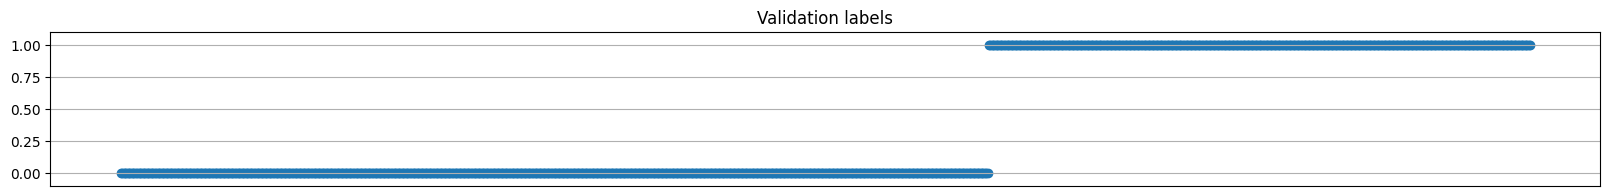

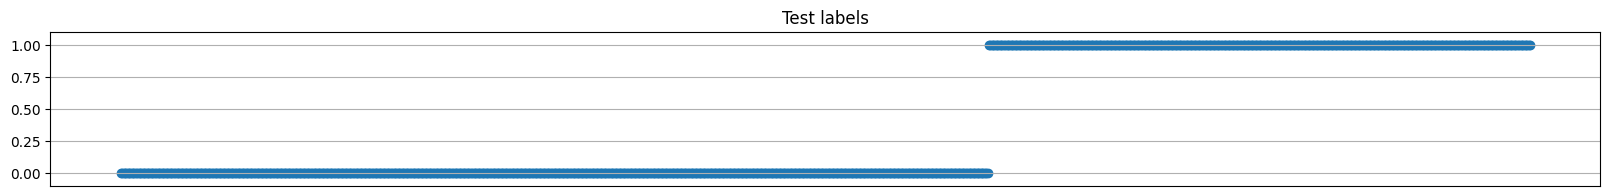

In [ ]:
# Create three separate subplots to visualize the sorted target variable values for the training, validation, and test sets

# Create a figure for the training labels subplot
plt.figure(figsize=(20, 2))
plt.scatter(np.arange(len(y_train)), np.sort(y_train, axis=0))
plt.title('Training labels')
plt.xticks([])  # Remove x-axis ticks
plt.grid(0.2)   # Add a grid with opacity 0.2 for reference
plt.ylim([-0.1, 1.1])  # Set the y-axis limits to [0.1, 1.1]

# Create a figure for the validation labels subplot
plt.figure(figsize=(20, 2))
plt.scatter(np.arange(len(y_val)), np.sort(y_val, axis=0))
plt.title('Validation labels')
plt.xticks([])  # Remove x-axis ticks
plt.grid(0.2)   # Add a grid with opacity 0.2 for reference
plt.ylim([-0.1, 1.1])  # Set the y-axis limits to [0.1, 1.1]

# Create a figure for the test labels subplot
plt.figure(figsize=(20, 2))
plt.scatter(np.arange(len(y_test)), np.sort(y_test, axis=0))
plt.title('Test labels')
plt.xticks([])  # Remove x-axis ticks
plt.grid(0.2)   # Add a grid with opacity 0.2 for reference
plt.ylim([-0.1, 1.1])  # Set the y-axis limits to [0.1, 1.1]

# Display the plots
plt.show()

### 6-Feature scaling

In [ ]:
x_train = x_train/255.0
x_val = x_val/255.0
x_test = x_test/255.0

### 7-Callbacks

In [ ]:
def Checkpoint(address):
  # CheckPoint callback ---> to save wieghts
  checkpoint_path = address # The path to save wights of the model after training
  My_ModelCheckpoint_callback =callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                          monitor='val_accuracy',
                                          verbose=1,
                                          save_weights_only=False,
                                          save_best_only=True,
                                          mode='max',
                                          save_freq ='epoch')
  return My_ModelCheckpoint_callback

In [ ]:
# EarlyStopping callback --> Stop learning if it does not see any imporvement.
My_EarlyStopping_callback = callbacks.EarlyStopping(monitor="val_accuracy",
                                                 min_delta=.02,
                                                 patience=15,
                                                 verbose=1,
                                                 mode="max",
                                                restore_best_weights=True)

In [ ]:
logdir = os.path.join("TensorBoardlogs_Folder", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
My_Tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

### 8-Create models

In [ ]:
# Define the input shape for the neural network, excluding the batch size
input_shape = x_train.shape[1:]
print('input_shape',input_shape)
# Define the batch size for training
batch_size = 64
# Define the number of training epochs
epochs = 100

input_shape (96, 96, 3)


####8-1 Model_1

In [ ]:
def model_1(input_shape=(96, 96, 3)):

  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu',
                          input_shape= input_shape))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))

  return model


In [ ]:
def compile(model):
   model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              metrics=[keras.metrics.Precision(), keras.metrics.Recall(),'accuracy'],)
   return model

In [ ]:
first_model = compile(model_1())

In [ ]:
first_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 47, 47, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 22, 22, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 10, 10, 128)       0

In [ ]:
My_all_callbacks = [ My_Tensorboard_callback, Checkpoint(address="best_models/First_model")]

In [ ]:
history = first_model.fit(
    x = x_train,
    y = y_train,
    validation_data = (x_val, y_val),
    batch_size = batch_size,
    epochs = epochs,
    callbacks=My_all_callbacks
).history

Epoch 1/100
49/49 [==============================] - ETA: 0s - loss: 0.6551 - precision: 0.5787 - recall: 0.1041 - accuracy: 0.6260
Epoch 1: val_accuracy improved from -inf to 0.63173, saving model to best_models/First_model
49/49 [==============================] - 15s 75ms/step - loss: 0.6551 - precision: 0.5787 - recall: 0.1041 - accuracy: 0.6260 - val_loss: 0.6381 - val_precision: 0.9048 - val_recall: 0.0475 - val_accuracy: 0.6317
Epoch 2/100
49/49 [==============================] - ETA: 0s - loss: 0.6094 - precision: 0.7038 - recall: 0.3106 - accuracy: 0.6843
Epoch 2: val_accuracy improved from 0.63173 to 0.68558, saving model to best_models/First_model
49/49 [==============================] - 3s 58ms/step - loss: 0.6094 - precision: 0.7038 - recall: 0.3106 - accuracy: 0.6843 - val_loss: 0.6044 - val_precision: 0.7296 - val_recall: 0.2900 - val_accuracy: 0.6856
Epoch 3/100
48/49 [============================>.] - ETA: 0s - loss: 0.5773 - precision: 0.6962 - recall: 0.3855 - accurac

In [ ]:
def plot_accuracy(model_history, name_of_model):
  # Create a figure for loss visualization
  plt.figure(figsize=(21, 4))

  # Plot training and validation loss
  plt.plot(history['accuracy'], label='Training loss', alpha=.2, color='#17becf')
  plt.plot(history['val_accuracy'], label='Validation loss', alpha=.8, color='#15becf')
  plt.title(f'Accuracy of {name_of_model}')
  plt.legend()
  plt.grid(alpha=.3)
  plt.show()


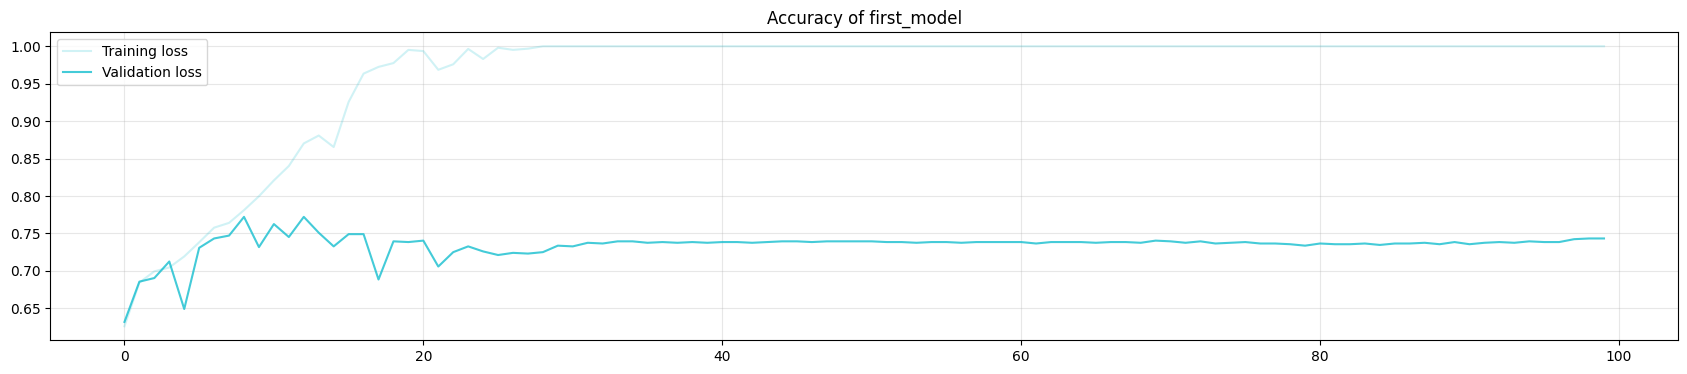

In [ ]:
plot_accuracy(model_history= history, name_of_model= "first_model")


In [ ]:
val_accuracy ={}

In [ ]:
val_accuracy['First']=np.max(history['val_accuracy'])

In [ ]:
!mkdir /content/last_models

In [ ]:
first_model.save("last_models/First_model.keras")

In [ ]:
def model_1_plus_Droput(input_shape=(96, 96, 3)):

  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu',
                          input_shape= input_shape))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(Dropout(0.25))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(Dropout(0.25))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(Dropout(0.25))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(Dropout(0.25))
  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))

  return model

In [ ]:
second_model = compile(model_1_plus_Droput())

In [ ]:
My_all_callbacks = [ My_Tensorboard_callback,Checkpoint(address="best_models/Second_model")]

In [ ]:
history = second_model.fit(
    x = x_train,
    y = y_train,
    validation_data = (x_val, y_val),
    batch_size = batch_size,
    epochs = epochs,
    callbacks=My_all_callbacks
).history

Epoch 1/100
49/49 [==============================] - ETA: 0s - loss: 0.6758 - precision_1: 0.3478 - recall_1: 0.0067 - accuracy: 0.6128
Epoch 1: val_accuracy improved from -inf to 0.61538, saving model to best_models/Second_model
49/49 [==============================] - 11s 100ms/step - loss: 0.6758 - precision_1: 0.3478 - recall_1: 0.0067 - accuracy: 0.6128 - val_loss: 0.6845 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_accuracy: 0.6154
Epoch 2/100
49/49 [==============================] - ETA: 0s - loss: 0.6535 - precision_1: 1.0000 - recall_1: 0.0017 - accuracy: 0.6157        
Epoch 2: val_accuracy did not improve from 0.61538
49/49 [==============================] - 2s 39ms/step - loss: 0.6535 - precision_1: 1.0000 - recall_1: 0.0017 - accuracy: 0.6157 - val_loss: 0.6651 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_accuracy: 0.6154
Epoch 3/100
47/49 [===========================>..] - ETA: 0s - loss: 0.6306 - precision_1: 0.6894 - recall_1: 0.1743 

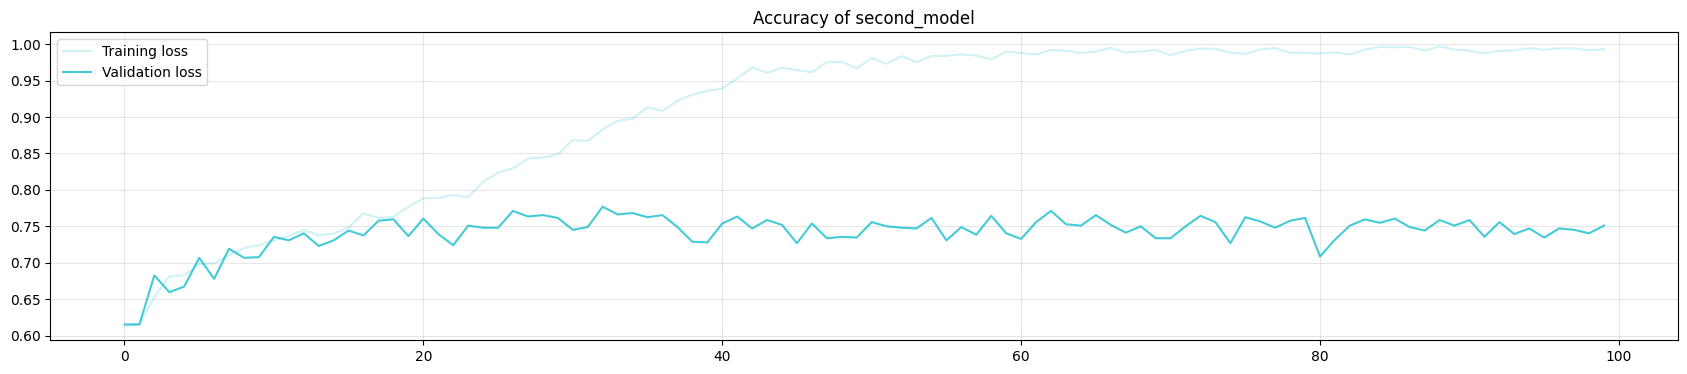

In [ ]:
plot_accuracy(model_history= history, name_of_model= "second_model")


In [ ]:
val_accuracy['Second']=np.max(history['val_accuracy'])

In [ ]:
second_model.save("last_models/Second_model.keras")

#### Data Augumentation

In [ ]:
My_all_callbacks = [ My_Tensorboard_callback,Checkpoint(address="best_models/Third_model")]

In [ ]:
def model_1_plus_Droput_aug(input_shape=(96, 96, 3)):

  preprocessing = tf.keras.Sequential([
        tfkl.RandomBrightness(0.2, value_range=(0,1)),
        tfkl.RandomTranslation(0.2,0.2),

    ], name='preprocessing')

  input_layer = tfkl.Input(shape=input_shape, name='Input')
  preprocessing = preprocessing(input_layer)


  x = tfkl.Conv2D(filters=32, kernel_size=3, name='conv0')(preprocessing)
  x = tfkl.ReLU(name='relu0')(x)
  x = tfkl.MaxPooling2D((2,2),name='mp0')(x)
  x = tfkl.Dropout(0.25)(x)

  x = tfkl.Conv2D(filters=64, kernel_size=3, name='conv1')(x)
  x = tfkl.ReLU(name='relu1')(x)
  x = tfkl.MaxPooling2D((2,2),name='mp1')(x)
  x = tfkl.Dropout(0.25)(x)

  x = tfkl.Conv2D(filters=128, kernel_size=3, name='conv2')(x)
  x = tfkl.ReLU(name='relu2')(x)
  x = tfkl.MaxPooling2D((2,2),name='mp2')(x)
  x = tfkl.Dropout(0.25)(x)

  x = tfkl.Conv2D(filters=128, kernel_size=3, name='conv3')(x)
  x = tfkl.ReLU(name='relu3')(x)
  x = tfkl.MaxPooling2D((2,2),name='mp3')(x)
  x = tfkl.Dropout(0.25)(x)

  x = tfkl.Flatten()(x)
  dense = tfkl.Dense(units=512, activation='relu',name='dense')(x)
  output_layer = tfkl.Dense(units=1, activation='sigmoid',name='outpu_layer')(dense)

   # Connect input and output through the Model class
  model = tfk.Model(inputs=input_layer, outputs=output_layer, name='CNN')

  return model

In [ ]:
third_model = compile(model_1_plus_Droput_aug())

In [ ]:
history = third_model.fit(
    x = x_train,
    y = y_train,
    validation_data = (x_val, y_val),
    batch_size = batch_size,
    epochs = epochs,
    callbacks=My_all_callbacks
).history

Epoch 1/100
49/49 [==============================] - ETA: 0s - loss: 0.6794 - precision_2: 0.1333 - recall_2: 0.0017 - accuracy: 0.6115
Epoch 1: val_accuracy improved from -inf to 0.61538, saving model to best_models/Third_model
49/49 [==============================] - 9s 106ms/step - loss: 0.6794 - precision_2: 0.1333 - recall_2: 0.0017 - accuracy: 0.6115 - val_loss: 0.6798 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_accuracy: 0.6154
Epoch 2/100
49/49 [==============================] - ETA: 0s - loss: 0.6570 - precision_2: 0.7273 - recall_2: 0.0400 - accuracy: 0.6247
Epoch 2: val_accuracy improved from 0.61538 to 0.69519, saving model to best_models/Third_model
49/49 [==============================] - 4s 77ms/step - loss: 0.6570 - precision_2: 0.7273 - recall_2: 0.0400 - accuracy: 0.6247 - val_loss: 0.6355 - val_precision_2: 0.6948 - val_recall_2: 0.3700 - val_accuracy: 0.6952
Epoch 3/100
47/49 [===========================>..] - ETA: 0s - loss: 0.6372 - precision_2:

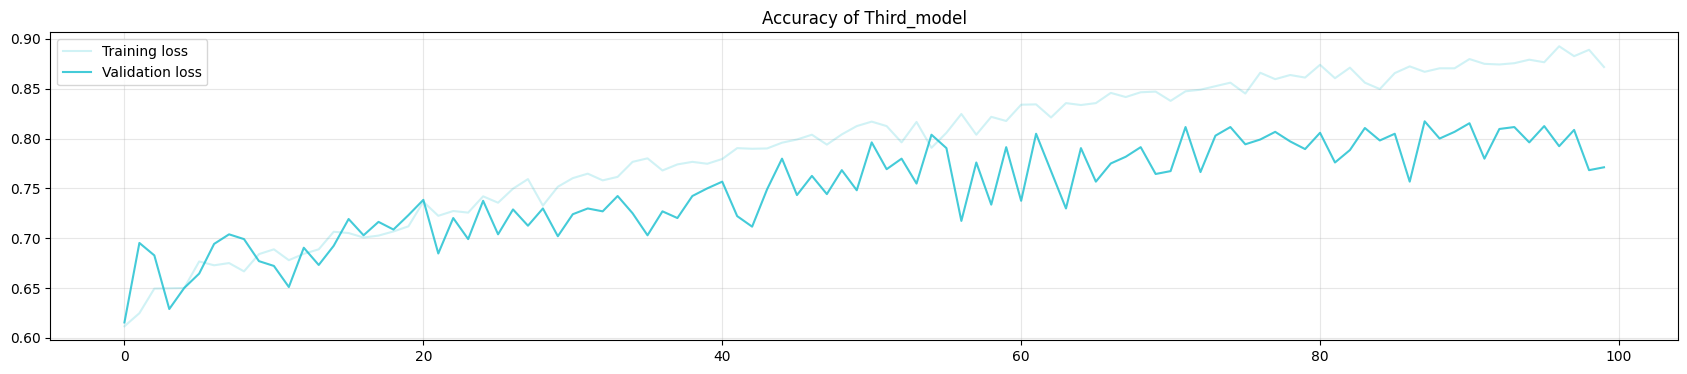

In [ ]:
plot_accuracy(model_history= history, name_of_model= "Third_model")

In [ ]:
val_accuracy['Third']=np.max(history['val_accuracy'])

In [ ]:
third_model.save("last_models/Third_model.keras")

In [ ]:
def trun_to_binary(value):
  if value > 0.5:
    value = 1
  else:
    value = 0
  return value

def prediction(type_model):
  test_accuracy = {}

  if type_model =="last_models":
    for i in (list(val_accuracy.keys())):
      test_model = tf.keras.models.load_model(f"/content/last_models/{i}_model.keras")
      y_pred = test_model.predict(x_test)
      y_pred = np.array(list(map(trun_to_binary, y_pred)))
      test_accuracy[f'{i}'] =  accuracy_score(y_test,y_pred)
    return test_accuracy

  elif type_model=="best_models":
    for i in (list(val_accuracy.keys())):
      test_model = tf.keras.models.load_model(f"/content/best_models/{i}_model")
      y_pred = test_model.predict(x_test)
      y_pred = np.array(list(map(trun_to_binary, y_pred)))
      test_accuracy[f'{i}'] =  accuracy_score(y_test,y_pred)
    return test_accuracy


In [ ]:
print("Val_accuracy:")
print(val_accuracy)
print("*"*50)
print("test_accuracy_with_last_models:")
print(prediction(type_model="last_models"))
print("test_accuracy_with_best_models:")
print(prediction(type_model="best_models"))

Val_accuracy:
{'First': 0.7721154093742371, 'Second': 0.7769230604171753, 'Third': 0.817307710647583}
**************************************************
test_accuracy_with_last_models:
33/33 [==============================] - 0s 4ms/step
{'First': 0.7278846153846154, 'Second': 0.7403846153846154, 'Third': 0.7817307692307692}
test_accuracy_with_best_models:
33/33 [==============================] - 0s 5ms/step
{'First': 0.7711538461538462, 'Second': 0.7519230769230769, 'Third': 0.8394230769230769}


In [ ]:
!cp -r "/content/best_models/Third_model" "/content/drive/MyDrive/Colab Notebooks"